<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# pip install fiftyone

In [2]:
# !pip install pycocotools

In [3]:
# !pip install torch torchvision fastai pycocotools

In [4]:
import os
from pycocotools.coco import COCO
import fiftyone as fo
import fiftyone.zoo as foz
from fastai.vision.all import *
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import warnings
warnings.filterwarnings('ignore')
import skimage.io as io
import matplotlib.pyplot as plt

In [5]:
# Path to the COCO annotation file
annotation_path = r"C:\Users\olga.poletkina\Documents\jupiter_notebooks\YPTeam_samolet\Olga\urbanhack-train\urbanhack-train\annotations\instances_default.json"

# Path to the directory containing the images
image_dir = r"C:\Users\olga.poletkina\Documents\jupiter_notebooks\YPTeam_samolet\Olga\urbanhack-train\urbanhack-train\images"

# Create a COCO object
coco = COCO(annotation_path)

# Get info on the dataset
categories = coco.loadCats(coco.getCatIds())
category_names = [category['name'] for category in categories]
print('Custom COCO categories: \n{}\n'.format(' '.join(category_names)))

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
Custom COCO categories: 
window empty filled



In [6]:
# Get all images containing a specific category
cat_ids_window = coco.getCatIds(catNms=['window']);
img_ids_window = coco.getImgIds(catIds=cat_ids_window);
imgs_window = coco.loadImgs(img_ids_window)
print(len(imgs_window))

111


In [7]:
# Get all images containing a specific category
cat_ids_empty = coco.getCatIds(catNms=['empty']); 
img_ids_empty = coco.getImgIds(catIds=cat_ids_empty);
imgs_empty = coco.loadImgs(img_ids_empty)
print(len(imgs_empty))

241


In [8]:
# Get all images containing a specific category
cat_ids_filled = coco.getCatIds(catNms=['filled']);
img_ids_filled = coco.getImgIds(catIds=cat_ids_filled);
imgs_filled = coco.loadImgs(img_ids_filled)
print(len(imgs_filled))

206


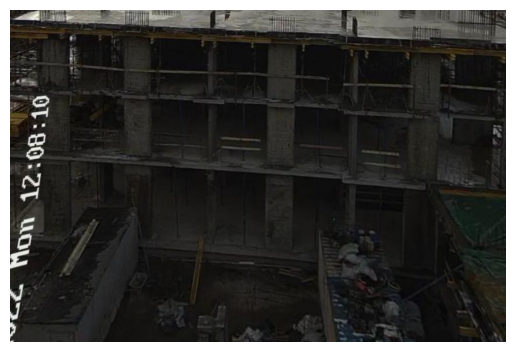

In [10]:
img = imgs_empty[0]
image_path = os.path.join(image_dir, img['file_name'])
I = io.imread(image_path)
plt.axis('off')
plt.imshow(I)
plt.show()

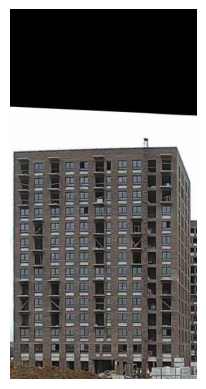

In [11]:
img = imgs_filled[0]
image_path = os.path.join(image_dir, img['file_name'])
I = io.imread(image_path)
plt.axis('off')
plt.imshow(I)
plt.show()

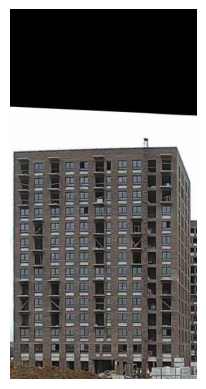

In [12]:
# Let's display an image
img = imgs_window[0]
image_path = os.path.join(image_dir, img['file_name'])
I = io.imread(image_path)
plt.axis('off')
plt.imshow(I)
plt.show()

In [13]:
fo.delete_dataset("my_dataset")

In [14]:
data_path = r"C:\Users\olga.poletkina\Documents\jupiter_notebooks\UrbanCode\urbanhack-train\urbanhack-train\images"
annotation_path = r"C:\Users\olga.poletkina\Documents\jupiter_notebooks\UrbanCode\urbanhack-train\urbanhack-train\annotations\instances_default.json"

# Load teh dataset
dataset = fo.Dataset.from_dir(
    data_path=data_path,
    dataset_type=fo.types.COCODetectionDataset,
    labels_path=annotation_path,
    name="my_dataset"
)


 100% |█████████████████| 252/252 [34.2s elapsed, 0s remaining, 17.4 samples/s]      


In [15]:
coco = COCO(annotation_path)
categories = coco.loadCats(coco.getCatIds())
category_names = [category['name'] for category in categories]
print('Custom COCO categories: \n{}\n'.format(' '.join(category_names)))

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
Custom COCO categories: 
window empty filled



In [16]:
def get_annotations_from_coco(annotations_file, img_path):
    # Инициализировать COCO API для аннотаций
    coco = COCO(annotations_file)
    
    # Получить ID изображения на основе имени файла
    img_id = coco.getImgIds(imgIds=[os.path.basename(img_path)])
    
    if not img_id:
        return []
    
    ann_ids = coco.getAnnIds(imgIds=img_id[0], iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    
    result = []
    
    for ann in anns:
        bbox = ann['bbox']
        # Преобразовать формат COCO bbox [x, y, width, height] в [x1, y1, x2, y2]
        bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
        label = coco.loadCats(ann['category_id'])[0]['name']
        result.append((bbox, label))
        
    return result

In [17]:
annos = get_annotations_from_coco(annotation_path, data_path)

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


In [18]:
annos

[]

In [19]:
def get_y(img_path):
    annos = get_annotations_from_coco(annotation_path, data_path)
    bboxes = [a[0] for a in annos]
    labels = [a[1] for a in annos]
    return [bboxes, labels]

In [20]:
data = DataBlock(
    blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
    get_items=get_image_files, 
    splitter=RandomSplitter(),
    get_y=get_y, 
    item_tfms=Resize(512),
    batch_tfms=aug_transforms()
)

dls = data.dataloaders(data_path, bs=16)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
# Initialize pretrained model
model = fasterrcnn_resnet50_fpn(pretrained=True)